In [35]:
import _pickle as pickle #data preprocessing
from collections import Counter #tokeniszation
import keras #ML
import glob
#import postprocessing as pr #helper


In [36]:
# Step 1 - Load data
pickle_folder = "pickle/"
def load_pickle_data(pickle_folder):
    heads = []
    desc = []
    keywords = []
    counter = 0
    
    pkl_paths = glob.glob(pickle_folder + "*.pkl")
    
    print("Loading...")
    for p in pkl_paths:
        counter = counter + 1
        with open(p, 'rb') as fp:
            pkl = pickle.load(fp)
            heads.append(pkl['headline'])
            desc.append(pkl['desc'])
            keywords.append(pkl['keywords'])
            
    print(str(counter) + " files loaded.")
    return heads, desc, keywords

In [37]:
heads, desc, keywords = load_pickle_data(pickle_folder)

Loading...
911 files loaded.


In [92]:
# Tokenize text

def get_vocab(lst):
    #print([w for txt in lst for w in txt.split()])
    #print([txt for txt in lst])
    
    c = Counter([w for txt in lst for w in txt.split()])
    vocab = list(c.keys())
    vocabcount = list(c.values())
    return vocab, vocabcount

vocab, vocabcount = get_vocab(heads + desc)

print (vocab[:50])
print (len(vocab))

['unrecycled,', 'Thailand', 'jams', 'Eighty', 'difficulties', 'fluent', 'disappearance', 'backfires', 'Stening,', 'widows"', 'feeding', 'Company,', 'profession', '"undervalued"', 'iPods', '£198m', 'FIFA', 'tapers', 'interview.', 'Buy,', 'strategies', 'impact.', 'map', 'phishing,', "Fox's", 'widen', 'appeal.', 'disagreements.', 'punitive', 'protest', 'Act', 'Walkman', 'plus-points', 'NEM', 'sources', 'rouble', 'fourth-largest', 'pandas', 'hard-to-find', "workers'", 'shows.', 'recognition', 'Riddick:', '(WSIS),', 'keystrokes.', '£4.6bn', 'roll', 'example', 'reputedly', 'Aggregate']
35650


In [94]:
# Create word embeddings with GloVe
#path = 'glove.6B.zip'
#glove_weights = get_glove_weights(path, origin = "https://nlp.stanford.edu/data/glove.6B.zip")


In [137]:
FN = 'vocabulary-embedding'
seed=42
vocab_size = 40000

embedding_dim = 100
lower = False # dont lower case the text

In [112]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [113]:
vocab, vocabcount = get_vocab(heads+desc)

In [114]:
print (list(vocab)[:50])
print (len(list(vocab)))

['the', 'to', 'of', 'and', 'a', 'in', 'is', 'that', 'for', 'The', 'on', 'it', 'be', 'said', 'are', 'has', 'as', 'by', 'with', 'will', 'have', 'was', 'at', 'its', 'from', 'which', '-', 'more', 'not', 'an', 'Mr', 'they', 'their', 'than', 'people', 'been', 'US', 'also', 'would', 'were', 'up', 'this', 'or', 'about', 'he', 'can', 'had', 'new', 'could', 'but']
35650


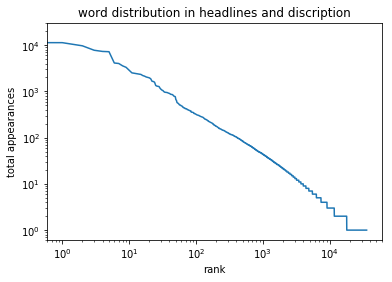

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');


In [116]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [129]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [130]:
word2idx, idx2word = get_idx(vocab, vocabcount)

In [161]:
# word embedding

fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
#if not os.path.exists(glove_name):
#    path = 'glove.6B.zip'
#    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
#    !unzip {datadir}/{path}

In [162]:
glove_name

'/home/ec2-user/.keras/datasets/glove.6B.100d.txt'

In [160]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

ValueError: invalid literal for int() with base 10: 'wc:'

In [152]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import generic_utils
import random, sys